In [1]:
# Standard libraries
import re
import warnings
from collections import Counter

# Data handling and processing
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Natural Language Processing
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# Topic Modeling with Gensim
import gensim
from gensim import corpora, models
from gensim.models import LdaModel, CoherenceModel
from gensim.utils import simple_preprocess

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aishwarya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aishwarya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aishwarya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
amz = pd.read_excel('/Users/Aishwarya/Desktop/LR/Amazon.xlsx')

In [3]:
amz.astype({'Tweet content': 'string', 'Tweet language': 'string', 'Company Name': 'string'}).dtypes

Date              datetime64[ns]
Tweet content     string[python]
Tweet language    string[python]
Is a RT                     bool
Company Name      string[python]
dtype: object

In [4]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [5]:
def preprocess_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)

    # Remove user mentions
    tweet = re.sub(r'@[^\s]+', '', tweet)

    # Remove special characters, punctuation, numbers, and hyphens
    tweet = re.sub(r'[^a-zA-Z\s\-]', '', tweet)

    # Remove retweet indicators
    tweet = re.sub(r'\brt\b', '', tweet)

    # Remove emojis
    tweet = remove_emojis(tweet)

    # Convert data to lowercase
    tweet = tweet.lower()

    # Removing stopwords
    clean_words = [word for word in tweet.split() if word.lower() not in stopwords.words('english')]

    return ' '.join(clean_words)

In [6]:
# Word tokenization
def word_tokenization(tweet):
    # Tokenization
    words = nltk.word_tokenize(tweet)
    return words

In [7]:
# Initialize spaCy 'en_core_web_sm' model, keeping only tagger component for efficiency
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Lemmatization function adapted to process text directly
def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if token.pos_ in allowed_postags])

In [8]:
# Create a new DataFrame for the cleaned tweet content
amz_1 = pd.DataFrame()

# Create a new DataFrame by copying the columns you want from the original DataFrame
amz_1 = amz[['Date', 'Tweet language', 'Is a RT', 'Company Name']].copy()

In [9]:
# Apply preprocessing and tokenization
amz_1['Tweet content'] = amz['Tweet content']
amz_1['Tweet content'] = amz_1['Tweet content'].apply(preprocess_tweet)
amz_1['Tweet content'] = amz_1['Tweet content'].apply(word_tokenization)

In [10]:
amz_1['Tweet content'] = amz_1['Tweet content'].astype(str)

In [11]:
amz_1['Tweet content'] = amz_1['Tweet content'].apply(lemmatization)

In [12]:
# Conversion of the other datas
amz_1 = amz_1.astype({'Tweet language': 'string', 'Company Name': 'string'})

In [13]:
amz_1['Tweet content']

0        try discovery engine amp social network invest...
1        halvorsen buy facebook amazon mastercard googl...
2        stock surprise investor earning season adbe tt...
3          oneplus launch price rs ' available amazon read
4             ocado share plummet amazon fresh launch read
                               ...                        
38187    ' amazon tick reboot aim stand crowd superhero...
38188    swear watch trade everytime sell stock take tw...
38189                                       amzn want roll
38190    minute trade spy dia qqq pcln tsla googl ' bid...
38191    wall cupboard browser ' app echo appliance eve...
Name: Tweet content, Length: 38192, dtype: object

In [14]:
# Extracting the text from the 'Tweet content' column
tweet_texts = amz_1['Tweet content'].dropna().tolist()  # Drops any NaN values and convert to list

# Tokenizing the text and converting to lowercase
words = [word.lower() for text in tweet_texts for word in re.findall(r'\b\w+\b', text)]

# Counting the frequency of each word
word_counts = Counter(words)

# Getting the most common 50 words
top_50_words = word_counts.most_common(50)

# Displaying the results
for word, count in top_50_words:
    print(f'{word}: {count}')

amazon: 9404
amzn: 6660
stock: 4304
read: 3888
goog: 3782
spy: 3590
googl: 3113
tsla: 3025
msft: 2702
qqq: 2627
buy: 2205
new: 2023
trade: 1994
sell: 1897
amp: 1487
earning: 1474
market: 1459
high: 1336
day: 1318
get: 1266
today: 1213
go: 1188
video: 1171
see: 1160
good: 1132
make: 1056
prime: 1043
apple: 1027
call: 1000
service: 969
baba: 960
big: 951
short: 942
take: 926
week: 901
say: 895
wmt: 894
cloud: 879
retail: 871
tech: 867
time: 863
top: 854
long: 852
share: 847
bezo: 836
look: 835
price: 824
dia: 786
next: 735
quant: 720


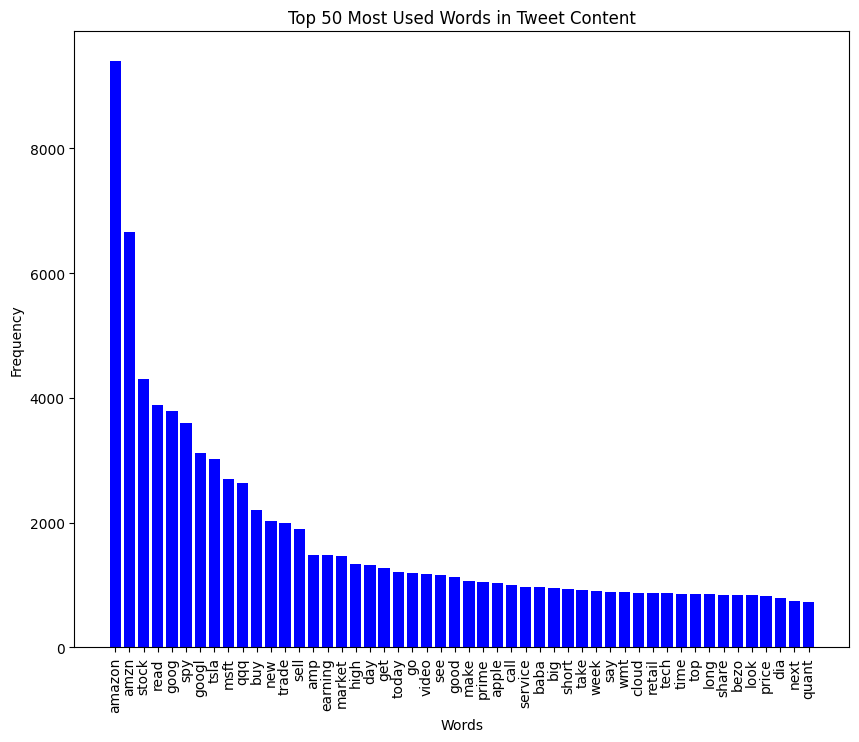

In [15]:
# Preparing data for plotting
words, frequencies = zip(*top_50_words)  # Unzipping the words and their counts

# Plotting
plt.figure(figsize=(10, 8))
plt.bar(words, frequencies, color='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.title('Top 50 Most Used Words in Tweet Content')
plt.show()

In [16]:
def replace_specific_words(text, replacements=None):
    # Mapping for words
    if replacements is None:
        replacements = {
            'amzn': 'amazon',
            'goog': 'google',
            'baba': 'ali baba',
            'tsla': 'tesla',
            'msft': 'microsoft',
            'fb': 'facebook',
            'aapl': 'apple',
            'googl': 'google',
            'twtr': 'twitter',
            'amazons': 'amazon',
            'googlee': 'google',
            'googleel': 'google',
            'nflx': 'netflix',
            'ali': 'ali baba',
            'lnkd': 'linkedin',
            'yhoo': 'yahoo',
            'googlele': 'google',
            'vrx': 'Valeant Pharmaceuticals International, Inc.'
        }

    for key, value in replacements.items():
        text = re.sub(r'\b' + re.escape(key) + r'\b', value, text, flags=re.IGNORECASE)
    return text

In [17]:
# Improved list of words to remove, ensuring lowercase for comparison (These have found with over multiple time iteration)
words_to_remove = ['new', 'buy', 'sell', 'day', 'today', 'see', 'like', 'top', 'may', 'week', 'inc', 'could', 'long', 'inc',
                   'via', 'amp', 'rt', 'read', 'video', 'pt', 'next', 'time', 'c', 'year', 'see', 'look', 'need', 'u', '-', 'x']

def remove_neutral_words(text, words_to_remove):
    # Ensure the list of words is unique and properly formatted
    words_to_remove = list(set([word.lower() for word in words_to_remove]))  # Make unique and lowercase

    # Add special characters '-' and "'" specifically to the list for removal
    words_to_remove.extend(['-', "'"])  # Adding hyphens and standalone apostrophes

    # Creating a pattern that matches any of the words or characters to remove
    pattern = r'\b(' + '|'.join(map(re.escape, words_to_remove)) + r')\b|(?<=\s)-|-\b|(?<=\s)\'|\'\b'

    # Replacing matched words and characters with nothing (i.e., removing them), case-insensitive
    cleaned_text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    # Removing extra spaces that may be left after word removal
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

In [18]:
# Applying the replace_specific_words to the 'Tweet content' column
amz_1['Tweet content'] = amz_1['Tweet content'].apply(replace_specific_words)

In [19]:
# Applying the remove_neutral_words to the 'Tweet content' column
amz_1['Tweet content'] = amz_1['Tweet content'].apply(lambda x: remove_neutral_words(x, words_to_remove))

In [20]:
# No null values are present which might cause errors in joining or splitting
amz_1['Tweet content'].dropna(inplace=True)

In [21]:
# Remove all single quotes and count the occurrences of each word in the 'Tweet content' column
all_words = ' '.join(amz_1['Tweet content'].str.replace("'", "")).split()
word_counts = Counter(all_words)

# Create a DataFrame from the word counts and sort by frequency
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

In [22]:
# Display the top 50 most common words
top_50_words = word_freq_df.head(50)

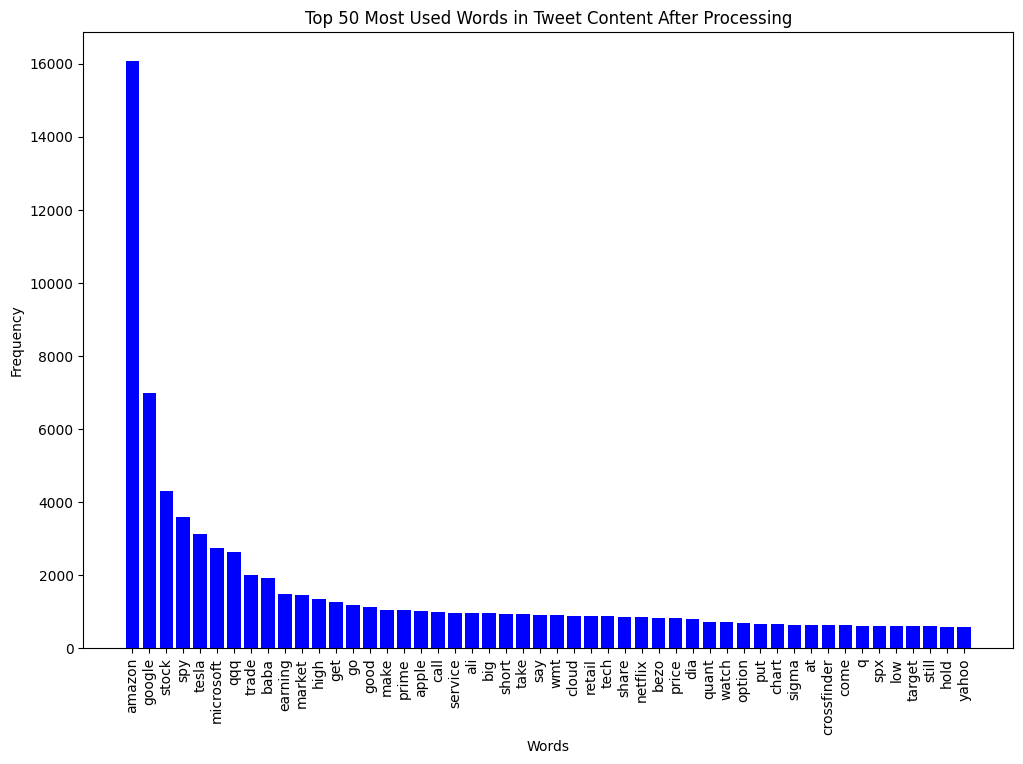

In [23]:
# Plotting
plt.figure(figsize=(12, 8))
plt.bar(top_50_words['Word'], top_50_words['Frequency'], color='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.title('Top 50 Most Used Words in Tweet Content After Processing')
plt.show()

In [24]:
# Convert the data type
amz_1.astype({'Tweet content': 'string', 'Tweet language': 'string', 'Company Name': 'string'}).dtypes

# Conversion
amz_1 = amz_1.astype({'Tweet content': 'string', 'Tweet language': 'string', 'Company Name': 'string'})

In [25]:
# Tokenize the cleaned tweets
amz_1['clean_tweet'] = amz_1['Tweet content'].apply(preprocess_tweet)
tokenized_tweets = amz_1['clean_tweet'].apply(lambda x: simple_preprocess(x, deacc=True))

# Create dictionary
dictionary = corpora.Dictionary(tokenized_tweets)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Create corpus
corpus = [dictionary.doc2bow(tweet) for tweet in tokenized_tweets]

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    # Defining the Range of Topic Numbers (Grid Search Setup)
    for num_topics in range(start, limit, step):
        # Applying the LDA Model
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42, alpha='auto', per_word_topics=True)
        model_list.append(model)
        # Evaluating Model Coherence
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Set parameters
start=2; limit=15; step=2
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokenized_tweets, start=start, limit=limit, step=step)

c:\Users\Aishwarya\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
c:\Users\Aishwarya\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
c:\Users\Aishwarya\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes

In [27]:
# Selecting the model and print the topics with the highest coherence score
best_model = model_list[coherence_values.index(max(coherence_values))]
topics = best_model.print_topics(num_words=7)
for topic in topics:
    print(topic)

(0, '0.123*"tesla" + 0.089*"microsoft" + 0.077*"google" + 0.069*"quant" + 0.066*"qqq" + 0.056*"sigma" + 0.055*"crossfinder"')
(1, '0.060*"dash" + 0.032*"add" + 0.029*"offer" + 0.027*"sale" + 0.026*"news" + 0.026*"product" + 0.022*"echo"')
(2, '0.053*"price" + 0.043*"target" + 0.040*"move" + 0.038*"wmt" + 0.033*"customer" + 0.030*"company" + 0.026*"rate"')
(3, '0.084*"cloud" + 0.067*"short" + 0.036*"analyst" + 0.036*"sbux" + 0.027*"wall" + 0.025*"line" + 0.023*"expect"')
(4, '0.098*"earning" + 0.034*"growth" + 0.033*"report" + 0.027*"beat" + 0.022*"stake" + 0.021*"increase" + 0.021*"large"')
(5, '0.132*"spy" + 0.070*"qqq" + 0.066*"baba" + 0.055*"google" + 0.042*"button" + 0.033*"ali" + 0.032*"tesla"')
(6, '0.355*"amazon" + 0.032*"prime" + 0.026*"get" + 0.023*"go" + 0.022*"netflix" + 0.022*"good" + 0.022*"service"')
(7, '0.212*"stock" + 0.117*"trade" + 0.045*"make" + 0.034*"tesla" + 0.025*"gpro" + 0.023*"free" + 0.022*"international"')
(8, '0.071*"high" + 0.070*"call" + 0.050*"option" + 

In [28]:
# Print coherence scores for each model
print("Coherence Scores for Each Topic:")
for i, score in enumerate(coherence_values):
    print(f"Num Topics: {1 + i*1}, Score: {score}")

Coherence Scores for Each Topic:
Num Topics: 1, Score: 0.3187494783474172
Num Topics: 2, Score: 0.3469211669200543
Num Topics: 3, Score: 0.36920292223040446
Num Topics: 4, Score: 0.37301873375029254
Num Topics: 5, Score: 0.371651873171775
Num Topics: 6, Score: 0.40926448782321073
Num Topics: 7, Score: 0.3904381515910543


- The coherence scores increase as the number of topics goes up, peaking at six topics, which indicates the most meaningful semantic relationship between words within the topics. Adding more topics beyond six doesn't significantly improve coherence, suggesting six is the optimal number of topics for this model.

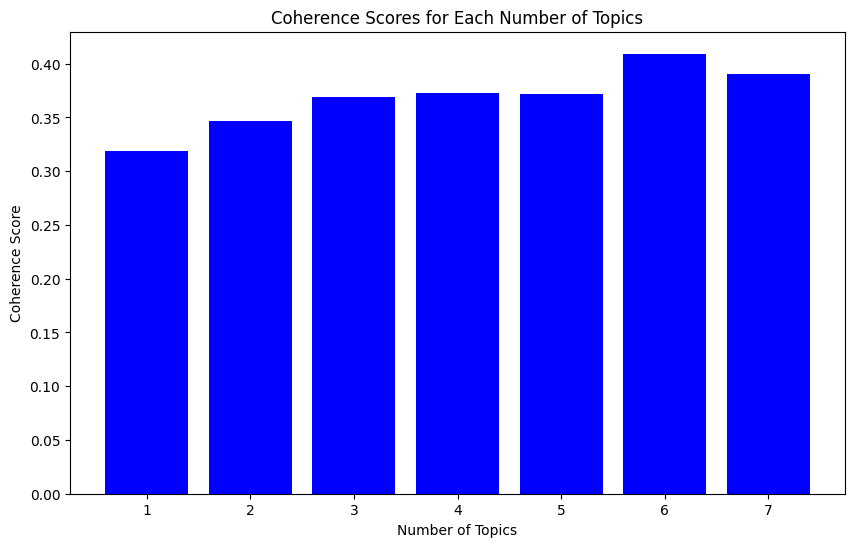

In [29]:
# Number of topics corresponding to the coherence values
num_topics = [1 + i for i in range(len(coherence_values))]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(num_topics, coherence_values, color='blue')

# Title and labels
plt.title('Coherence Scores for Each Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics)

# Display the plot
plt.show()

# LDA Visualisation
- The size of the bubbles can represent various metrics like the marginal topic distribution, indicating how much text is associated with each topic.
- When λ equals 1, terms are ranked based only on how likely they are within the topic, which might favor common terms. When λ equals 0, terms are ranked solely by their uniqueness, highlighting more unusual terms. Adjusting λ lets you explore different aspects of how terms contribute to a topic, refining its description.
- The map visualizes the topics on a two-dimensional plane using multidimensional scaling (MDS). The closer two topics are on this map, the more similar they are in terms of their content and term composition
- These metrics provide insight into how often terms appear in general versus within specific topics.

**The Formulas:**
- Saliency is a measure of how much a term both appears frequently and distinctively in a topic. 
- Relevance combines the frequency of a term within a topic (its exclusivity) and across all documents, adjusted by λ.


In [30]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_model, corpus, dictionary)
pyLDAvis.display(vis)

# General Topic Overview

- ***Online Retail and Streaming Services:***
Dominated by discussions on e-commerce and streaming platforms, with a strong focus on Amazon's products, services, and leadership. Keywords point towards business strategy and market competition.

- ***Financial Markets and Tech Industry:***
Merges finance with technology, analyzing stock performances of tech giants and financial instruments. It encompasses market dynamics, investment strategies, and the impact of AI on finance.

- ***Tech Giants and Financial Performance:***
Focuses on the business outcomes of leading tech firms, their stock movements, and innovation impacts. It spans discussions from company earnings to advancements in AI and data.

- ***Stock Trading and Market Analysis:***
Centers on the trading sphere, highlighting company-specific stock discussions, market trends, and trading strategies. It also touches upon the community aspect of trading and retail brokerage.

- ***Retail Strategy and Consumer Engagement:***
Delivers insights into retail giants' strategies, pricing, logistics, and digital commerce. It deals with customer service approaches, market speculation, and the integration of technology in retail.

# Results:
- In ***Topic 1*** counting 20.3% of tokens and terms like "amazon", "prime", "get", "go", and "netflix" likely indicate discussions around online retail and streaming services, hinting at the competition and comparison in the market. "Bezos", "kindle", "aws", and "Jeff" point specifically to Amazon-related discussions, suggesting that Topic 1 may encompass conversations about Amazon's products (like Kindle), services (such as AWS), and perhaps commentary about its executive leadership (notably Jeff Bezos). The presence of words like "expand", "launch", "plan", "deal", "business", and "ceo" implies a focus on business strategies and development activities. This topic, therefore, seems to capture a business-oriented dialogue, with a strong focus on Amazon's ecosystem, competitive positioning in the market, strategic moves, and leadership perspectives.

- In ***Topic 2*** representing 10.6% of tokens, this topic blends technology and finance, highlighting stock market discussions with references to tech giants and ETFs like "SPY" and "QQQ". Terms such as "stockmarket", "vix", and "finance" suggest a focus on market trends, investment strategies, and commodity trading. The presence of "gs" and "jpm" underscores a look at financial services, while "artificial" and "intelligence" indicate the impact of AI on the sector. It also touches on trading and commodities, showing the interplay between tech innovation and financial markets.

- ***Topic 3*** accounts for 10.5% of tokens, centering on the business and financial aspects of leading tech companies like "Google", "Microsoft", "Apple", and "Facebook". It deals with stock performance, company earnings, and investment in the tech sector. The topic extends to e-commerce, telecoms, and wearables with mentions of "Yahoo", "eBay", and "Fitbit". It also touches on the effects of "AI" and "data" on market trends. Essentially, it's a discussion on the financial and innovative progress of tech companies.

- ***Topic 4*** making up 8.5% of tokens, revolves around the stock market with terms like "stock" and "trade" emphasizing trading discussions. It includes talk of profits, investments, and company financials, citing companies like GoPro and Tesla. Words such as "huge" and "volatility" imply significant market events and trading dynamics, while "trend" and "daytrade" suggest analytic discussions. Terms like "chatroom" point to the community aspect of trading. "Scottrade" signals retail trading involvement. This topic merges talk on company stocks, trading tactics, and trader interactions.

- ***Topic 5***, represented in the graph, focuses on retail strategy and customer engagement with 7% of the tokens, evidenced by terms such as "price", "target", and "customer". It suggests discussions around pricing, sales goals, and consumer relations, with "wmt" and "tgt" pointing to large retailers like Walmart and Target. Business performance and growth strategy are also touched upon, as indicated by terms like "company", "build", and "rate". The integration of technology in retail, such as drone logistics, and the management of brands and teams are further discussed. Additionally, words like "bet" and "feel" hint at market speculation. The term "web" underscores the importance of e-commerce in these retail strategies. Overall, this topic encapsulates retail giants' approaches to market operations, online engagement, and logistics.